<img src="https://s.udemycdn.com/meta/default-meta-image-v2.png" />

This project is based on the [dataset](https://drive.google.com/drive/folders/11XO-3tqFYhkwPzb0O8gUFDi8j67QVLQb) for the [Udemy Data Analytics Project](https://medium.com/@ayomideoshikoya/udemy-data-analytics-project-da7424503305) published on Medium. A member of the data team at Udemy had worked on the project with excel and visualised with PowerBI but I will be using python and PowerBI.

The scope of the project covers only four course categories: `Business Finance`, `Graphics Design`, `Musical Instruments` and `Web Development`.

The aim is to explore the number of courses for each subject area, the number of subscribers, how well the courses were rated and how much revenue is being generated etc. For each subject category, we will also identify the key words for the most best rated and most sought after courses.. 

**We will find answers to the following questions and more:**
- Which subject area has the highest and lowest number of published courses?
- Which subject area has the highest number of subscribers?
- What levels of courses are free?
- What words are common among the courses with high ratings and number of subscriptions?
- How well were the courses rated by subscribers?
- For each subject category, what year were most courses published?
- Which suject area contributes the most to the companies revenue?

### Import Packages and Load Data

In [1]:
"""
Import the packages we need for our analysis.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string, re, nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import datetime
import plotly.express as px
import warnings

####  Business, Music, Design, Web Development  Data
Using the `read_csv` built-in function, load the datasets onto jupyter notebook.

In [2]:
"""
Load the four different datasets into dataframes.
"""

df_biz = pd.read_csv("C:\\Users\\user\\Downloads\\Business Courses.csv") #Business Finance
df_gfx = pd.read_csv("C:\\Users\\user\\Downloads\\Design Courses.csv") #Graphics
df_mus = pd.read_csv("C:\\Users\\user\\Downloads\\Music Courses.csv") #Musical Instrument
df_dev = pd.read_csv("C:\\Users\\user\\Downloads\\Web development Courses.csv") #Web Development

#join the dataframes
df = pd.concat([df_biz, df_gfx, df_mus, df_dev])

#sample the first rows of the dataframe
print('\n')
print("This combined dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]) )
df.head(2)



This combined dataset has 3681 rows and 12 columns


course_id                                       course_title  \
0    49798.0  Bitcoin or How I Learned to Stop Worrying and ...   
1    48841.0    Accounting in 60 Minutes - A Brief Introduction   

                                                 url  price  num_subscribers  \
0  https://www.udemy.com/bitcoin-or-how-i-learned...    0.0          65576.0   
1  https://www.udemy.com/accounting-in-60-minutes...    0.0          56659.0   

   num_reviews  num_lectures           level  Rating  content_duration  \
0        936.0          24.0      All Levels    0.56               8.0   
1       4397.0          16.0  Beginner Level    0.95               1.5   

    published_timestamp           subject  
0  2013-04-20T02:25:22Z  Business Finance  
1  2013-04-07T21:39:25Z  Business Finance

In [3]:
#summary statistics of the combined dataframe
df.describe()

course_id        price  num_subscribers   num_reviews  num_lectures  \
count  3.676000e+03  3676.000000      3676.000000   3676.000000   3676.000000   
mean   6.757535e+05    66.115343      3199.260881    156.309848     40.129761   
std    3.431304e+05    61.056073      9486.582966    935.674518     50.398507   
min    8.324000e+03     0.000000         0.000000      0.000000      0.000000   
25%    4.074740e+05    20.000000       112.000000      4.000000     15.000000   
50%    6.876920e+05    45.000000       912.500000     18.000000     25.000000   
75%    9.608140e+05    95.000000      2558.000000     67.000000     46.000000   
max    1.282064e+06   200.000000    268923.000000  27445.000000    779.000000   

            Rating  content_duration  
count  3677.000000       3676.000000  
mean      0.610889          4.096137  
std       0.334244          6.054948  
min       0.000000          0.000000  
25%       0.280000          1.000000  
50%       0.760000          2.000000  
75%       0.930000          4.500000  
max       1.000000         78.500000

### Data Wrangling

In [4]:
#check data types and missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3681 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3676 non-null   float64
 1   course_title         3676 non-null   object 
 2   url                  3676 non-null   object 
 3   price                3676 non-null   float64
 4   num_subscribers      3676 non-null   float64
 5   num_reviews          3676 non-null   float64
 6   num_lectures         3676 non-null   float64
 7   level                3676 non-null   object 
 8   Rating               3677 non-null   float64
 9   content_duration     3676 non-null   float64
 10  published_timestamp  3676 non-null   object 
 11  subject              3677 non-null   object 
dtypes: float64(7), object(5)
memory usage: 373.9+ KB


In [5]:
#check for and drop duplicates
df[df.duplicated()]

#drop duplicates in the course id column
df.drop_duplicates(subset=['course_id'],inplace=True)

In [6]:
#drop rows with missing values
df.dropna(inplace=True)

#confirm there is no more any null values
df.isnull().sum()

course_id              0
course_title           0
url                    0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
Rating                 0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

We wouldn't be needing the columns below for our analysis; hence we shall drop them. We will change the column data types to the most suitable.

In [7]:
"""
We do not need all the attributes for our analysis; therefore we choose only the relevant ones to study and drop the rest.
"""

df = df.drop(['url','num_reviews', 'course_id', 'num_lectures','content_duration'], axis = 1)

In [8]:
#cast datatype as int
df['num_subscribers'] = df['num_subscribers'].astype('int64')


#confirm change
df.head(2)

course_title  price  num_subscribers  \
0  Bitcoin or How I Learned to Stop Worrying and ...    0.0            65576   
1    Accounting in 60 Minutes - A Brief Introduction    0.0            56659   

            level  Rating   published_timestamp           subject  
0      All Levels    0.56  2013-04-20T02:25:22Z  Business Finance  
1  Beginner Level    0.95  2013-04-07T21:39:25Z  Business Finance

In [9]:
#categorize courses as either free or paid
conditions = [
    (df['price'] == 0), 
    (df['price'] > 0)]

values  = ['free', 'paid']
df['price_group'] = np.select(conditions, values)

df['price_group'].value_counts()

paid    3362
free     310
Name: price_group, dtype: int64

Below we will group the ratings into bins to allow for some easy referencing.

In [11]:
"""
We want to create a categorical variable for the `Rating` to enable us track how the courses where rated.
"""

conditions1 = [
    (df['Rating'] == 0),
    (df['Rating'] > 0) & (df['Rating'] < 0.2),
    (df['Rating'] >= 0.2) & (df['Rating'] < 0.4),
    (df['Rating'] >= 0.4) & (df['Rating'] < 0.6),
    (df['Rating'] >= 0.6) & (df['Rating'] < 0.8),
    (df['Rating'] >= 0.8) 
]
values1 = [0, 1, 2, 3, 4, 5]

df['star_rating'] = np.select(conditions1, values1)

df['star_rating'].value_counts()

5    1543
1     735
4     610
2     428
3     338
0      18
Name: star_rating, dtype: int64

In [13]:
"""
Change naming of the course levels into a more relatable nomenclature.
"""

levels = ({'All Levels':'General', 'Beginner Level':'Beginner', 
           'Intermediate Level':'Intermediate', 'Expert Level':'Expert'})
df['level'] = df['level'].replace(levels)

df['level'].value_counts()

General         1925
Beginner        1268
Intermediate     421
Expert            58
Name: level, dtype: int64

Let us extract the date only object from the datetime supplied; we wont be needing the time object for this analysis. We will then create the `year` column.

In [12]:
#extract date only from datetime object
df['published'] = df['published_timestamp'].str.split('T').str[0]

df = df.drop(['published_timestamp'], axis = 1) #drop the combined timestamp column

df['published']

0       2013-04-20
1       2013-04-07
2       2013-12-25
3       2014-05-27
4       2016-01-21
           ...    
1200    2017-05-29
1201    2017-07-06
1202    2017-06-11
1203    2017-06-15
1204    2017-06-28
Name: published, Length: 3672, dtype: object

In [13]:
#create column for the year the course was published

df['year'] = (df['published'].str.split('-').str[0]).astype(int)
df['year'].value_counts()

2016    1204
2015    1014
2017     713
2014     490
2013     201
2012      45
2011       5
Name: year, dtype: int64

Let us clean the text columns a bit.

In [15]:
"""
Let us create a regex function to clean the text column off: 
- urls 
- punctuation 
- special characters
"""

def clean(text):
    text = str(text).title()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove url
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]', '', text)
    text = re.sub('<.*?>+', '', text)
    return text

#apply the function created
df['course_title'] = df['course_title'].apply(clean)

In [16]:
#clean off punctautions from subject column

df['subject']=df['subject'].str.split(': ').str[-1].str.lstrip()
df['subject'].value_counts()

Web Development        1199
Business Finance       1191
Musical Instruments     680
Graphic Design          602
Name: subject, dtype: int64

Let us create the `Revenue` column by multiplying the `num_subscribers` by `price` of the course.

In [16]:
df['revenue'] = df['num_subscribers'] * df['price']

In [17]:
#separate the component dataframes
df_biz = df.query('subject == "Business Finance"')
df_gfx = df.query('subject == "Graphic Design"')
df_mus = df.query('subject == "Musical Instruments"')
df_dev = df.query('subject == "Web Development"')

print('There are {} {} courses'.format(df_biz.shape[0], df_biz.subject[0]))
print('There are {} {} courses'.format(df_gfx.shape[0], df_gfx.subject[0]))
print('There are {} {} courses'.format(df_mus.shape[0], df_mus.subject[0]))
print('There are {} {} courses'.format(df_dev.shape[0], df_dev.subject[0]))


There are 1191 Business Finance courses
There are 602 Graphic Design courses
There are 680 Musical Instruments courses
There are 1199 Web Development courses


**Data Cleaning Steps:**
- Checked datatypes and missing values.
- Dropped null values from the dataframe.
- Created a column to categorize the courses into free and paid.
- Extracted and stored the date only data from the datetime column and created the `year` column.
- Created a function with regex to clean up the text columns.
- Dropped off columns that are not necesary for the analysis.
- Created the `revenue` column.

In [18]:
df.to_csv('C:\\Users\\user\\OneDrive\\Desktop\\person data projects\\datasets\\udemy_cleaned.csv')

### Exploratory Data Analysis

From the pie chart below, *Web Development* leads with **1203** courses while *Graphics Designs* at **602** courses is the least.

In [19]:
#plot the course category

#extract only the subject name
df['subject'] = df['subject'].str.split(': ').str[-1]
df['subject'] = df['subject'].str.lstrip(' ')

subject = df['subject'].value_counts()

print(df['subject'].value_counts())
figure = px.pie(df, 
                values = subject.values,
                names = subject.index,
                hole = 0.5)
figure.show()



Web Development        1199
Business Finance       1191
Musical Instruments     680
Graphic Design          602
Name: subject, dtype: int64


`Web Development` courses were generally more expensive closely followed by `Business Finance` courses. Nevertheless, `Web Development` courses had more subscribers and above average rating. The best rated courses are in Business and Graphics.

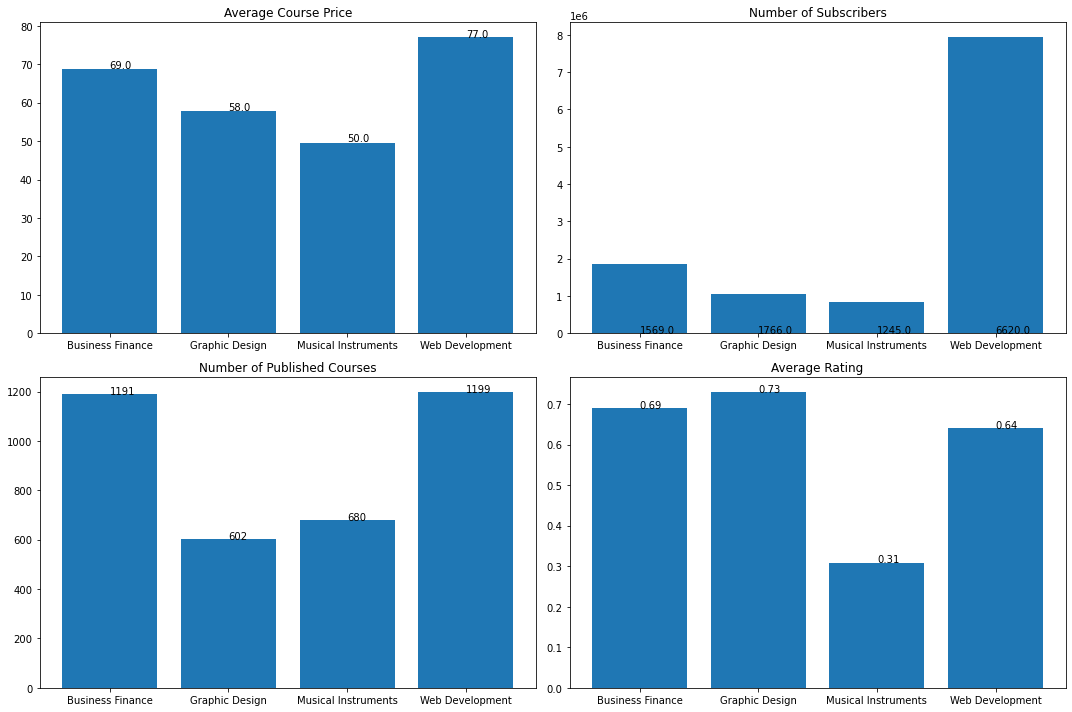

In [20]:
#course price versus number of subscribers
fig, ((ax0, ax1), (ax2, ax3 )) = plt.subplots(2,2 ,figsize=(15,10))

values = df.groupby('subject')['price'].mean().round()
ax0.bar(df.groupby('subject')['price'].mean().index, df.groupby('subject')['price'].mean() )
ax0.set_title('Average Course Price')
[ax0.text(index, value, str(value)) for index, value in enumerate(values)] #list comprehension to add bar values
    
values = df.groupby('subject')['num_subscribers'].mean().round()    
ax1.bar(df.groupby('subject')['num_subscribers'].sum().index, df.groupby('subject')['num_subscribers'].sum())
ax1.set_title('Number of Subscribers')
[ax1.text(index, value, str(value)) for index, value in enumerate(values)]

values = df.groupby('subject')['course_title'].count()
ax2.bar(df.groupby('subject')['course_title'].count().index, df.groupby('subject')['course_title'].count())
ax2.set_title('Number of Published Courses')
[ax2.text(index, value, str(value)) for index, value in enumerate(values)]

values = df.groupby('subject')['Rating'].mean().round(2)
ax3.bar(df.groupby('subject')['Rating'].mean().index, df.groupby('subject')['Rating'].mean())
ax3.set_title('Average Rating')
[ax3.text(index, value, str(value)) for index, value in enumerate(values)]

plt.tight_layout()
plt.show()

*Web Development* and *Business Finance* have the highest number of paid courses by absolute count; however the percentage free courses is highest in *Web Development*. The expert category has more free courses out of the total published in that level.

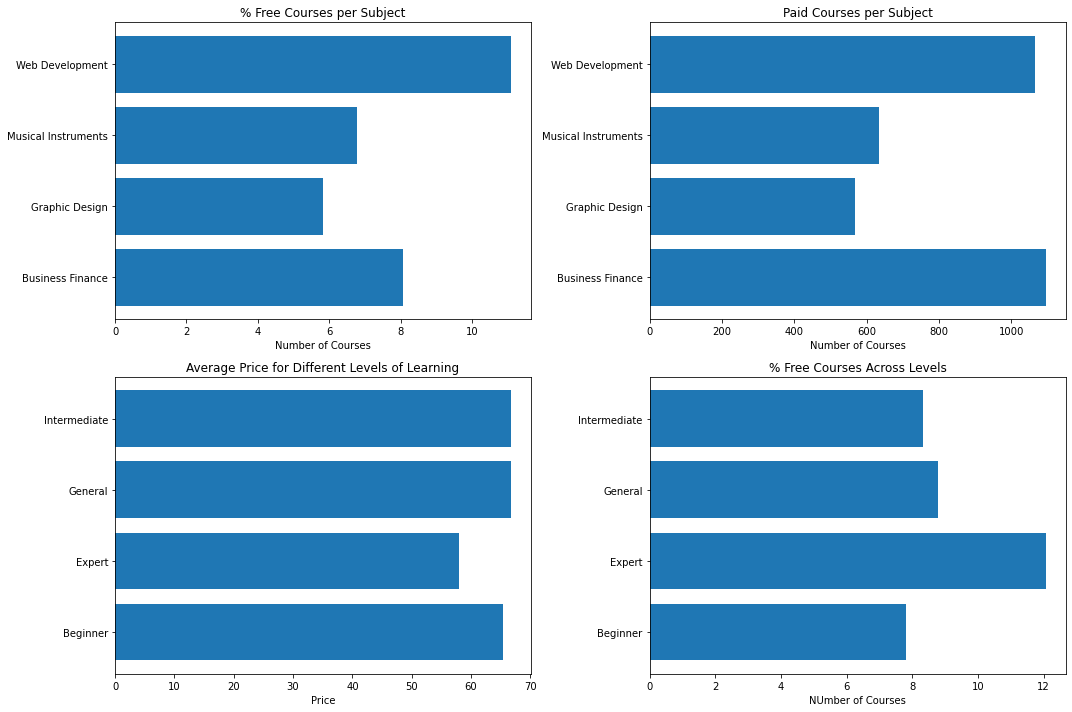

In [21]:
#revenue generation by subject and by course
fig, ((ax0,ax1), (ax2,ax3)) = plt.subplots(2,2 ,figsize=(15,10))

df_free = df.query('price == 0')
(ax0.barh(df_free.groupby('subject')['course_title'].count().index, 
          100*df_free.groupby('subject')['course_title'].count()/
          df.groupby('subject')['course_title'].count()))
ax0.set_title('% Free Courses per Subject')
ax0.set_xlabel('Number of Courses')

df_paid = df.query('price != 0')
ax1.barh(df_paid.groupby('subject')['course_title'].count().index, df_paid.groupby('subject')['course_title'].count())
ax1.set_title('Paid Courses per Subject')
ax1.set_xlabel('Number of Courses')

ax2.barh(df.groupby('level')['price'].mean().index, df.groupby('level')['price'].mean())
ax2.set_title('Average Price for Different Levels of Learning')
ax2.set_xlabel('Price')

df_free = df.query('price == 0')
(ax3.barh(df_free.groupby('level')['course_title'].count().index, 
          100*df_free.groupby('level')['course_title'].count()/
          df.groupby('level')['course_title'].count()))
ax3.set_title('% Free Courses Across Levels')
ax3.set_xlabel('NUmber of Courses')

plt.tight_layout()
plt.show()

The *The Developer Bootcamp* course, a course on *Web Development*, generates the highest revenue; 90% of the top 20 revenue generating courses are from the Web Development category.

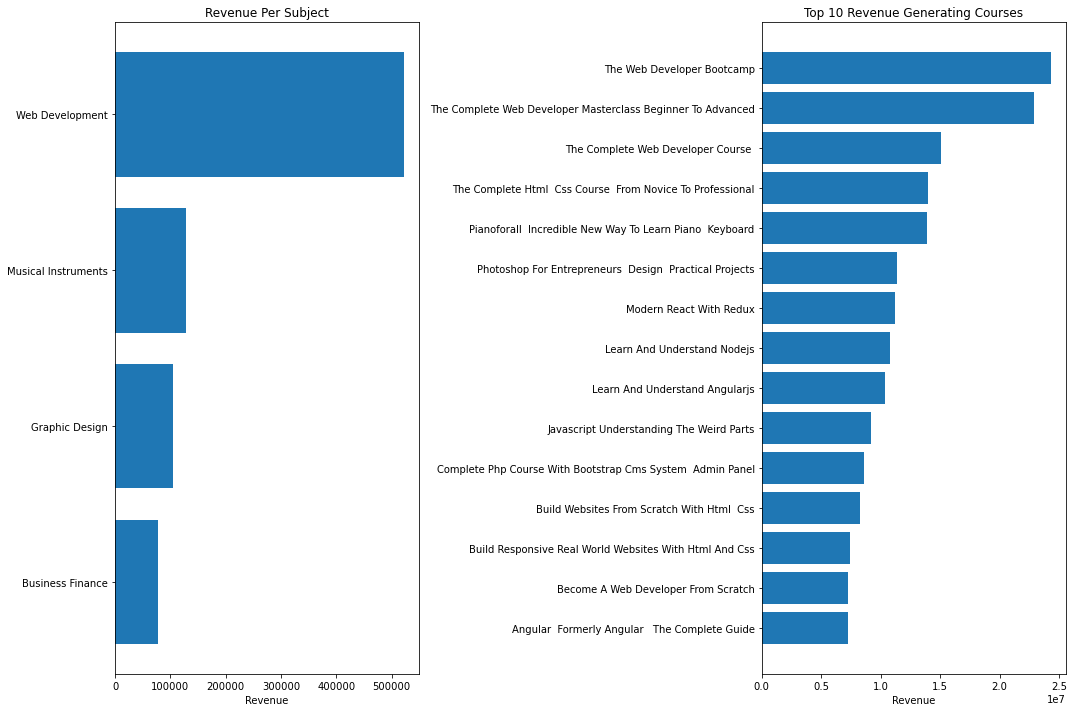

In [22]:
#revenue generation by subject and by course
fig, ((ax0), (ax1)) = plt.subplots(1, 2 ,figsize=(15,10))

(ax0.barh(df.groupby('subject')['revenue'].sum().index, sorted(df.groupby('subject')['revenue'].mean())))
ax0.set_title('Revenue Per Subject')
ax0.set_xlabel('Revenue')


#sort the dataframe by revenue generated and courses and plot top 15
df_rev = df[['course_title', 'revenue']].sort_values('revenue', ascending=False).head(15)
(ax1.barh(df_rev.head(15).groupby('course_title')['revenue'].sum().index, 
          sorted(df_rev.head(15).groupby('course_title')['revenue'].sum())))
ax1.set_title('Top 10 Revenue Generating Courses')
ax1.set_xlabel('Revenue')

plt.tight_layout()
plt.show()

Out of the first 20 most subscribed courses, **60%** are free, **85%** are *Web Development* courses.

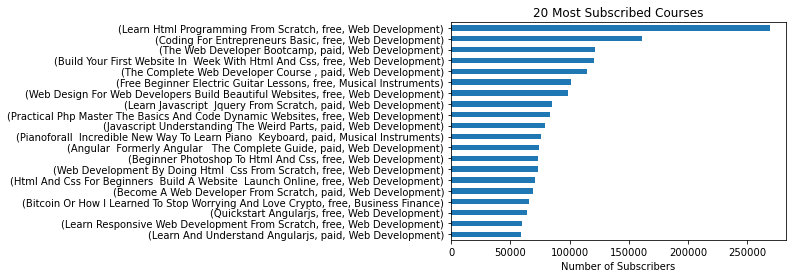

In [23]:
#plot of the courses by number of subscribers
df_sub = df.sort_values('num_subscribers', ascending=False).head(20)
df_sub.groupby(['course_title', 'price_group','subject'])['num_subscribers'].sum().sort_values().plot(kind='barh')
plt.title('20 Most Subscribed Courses')
plt.ylabel('')
plt.xlabel('Number of Subscribers')
plt.rcParams["figure.figsize"] = (10, 12)
plt.show()

A distribution plot of the `price` and `rating` of the courses below reveals that most of the courses are between `$20 and $60`, and received high ratings.

<ipython-input-24-7cbe3387a623>:5: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



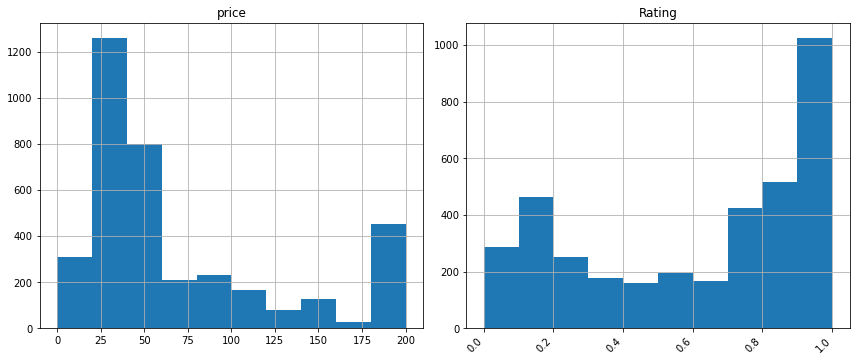

In [24]:
#distribution chart of selected attributes
fig = plt.figure(figsize = (12,5))
ax = fig.gca()

df[['price', 'Rating']].hist(ax = ax)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
warnings.filterwarnings("ignore")

plt.show()

There is no proportionate linear relationship between the `price` of the courses and the `rating` they got.

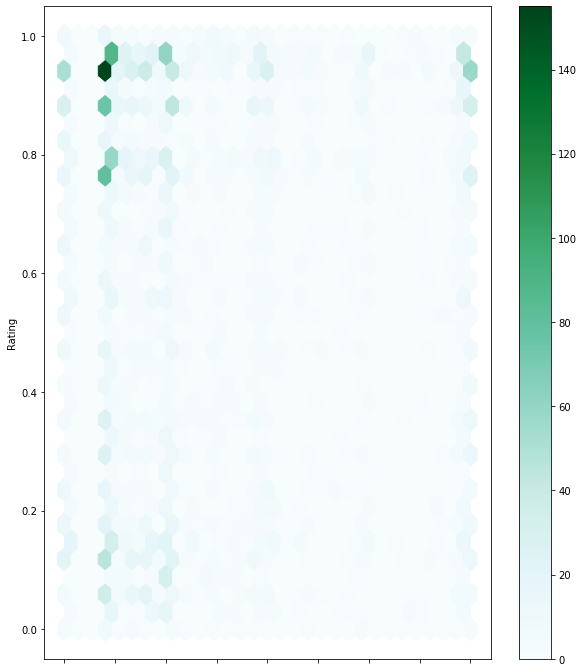

In [25]:
df.plot.hexbin(x='price', y='Rating', gridsize=30)
plt.show()

Besides courses on `Musical Instruments` which has a little bit of balance, there are more people going for the less expensive courses.

subject
Business Finance       68.694374
Graphic Design         57.890365
Musical Instruments    49.558824
Web Development        77.035029
Name: price, dtype: float64


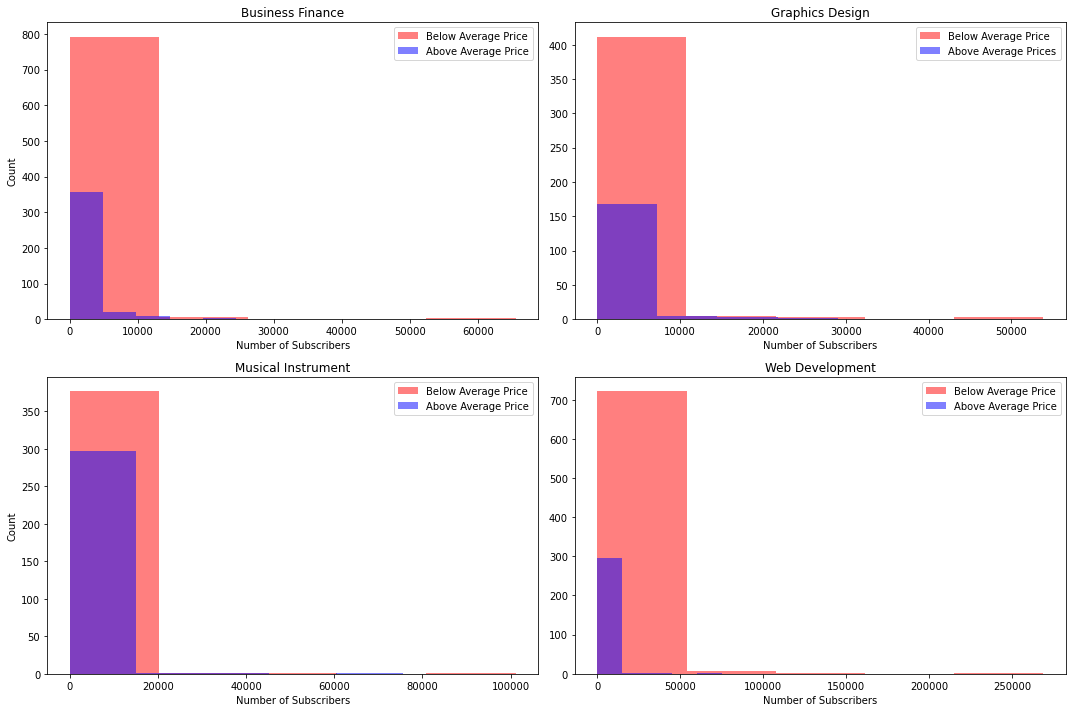

In [26]:
#average price of course per category
print(df.groupby('subject')['price'].mean())

#use power query to categorize dataset based on the average price
below_biz = df_biz.query('price < 68.694374')
above_biz = df_biz.query('price >= 68.694374')

below_gfx = df_gfx.query('price < 57.890365')
above_gfx = df_gfx.query('price >= 57.890365')

below_mus = df_mus.query('price < 49.558824')
above_mus = df_mus.query('price >= 49.558824')

below_dev = df_dev.query('price < 77.036575')
above_dev = df_dev.query('price >= 77.036575')

#use this to compare number of courses, rating etc below and above the median(or average) price
#double hist plot function

fig, ((ax0, ax1), (ax2, ax3 )) = plt.subplots(2,2 ,figsize=(15,10))

ax0.hist(below_biz.num_subscribers, 5, color ='r', alpha = 0.5, label='Below Average Price')
ax0.hist(above_biz.num_subscribers, 5, color ='b', alpha = 0.5, label='Above Average Price')
ax0.legend(prop={'size': 10})
ax0.set_xlabel('Number of Subscribers')
ax0.set_ylabel('Count')
ax0.set_title('Business Finance')

ax1.hist(below_gfx.num_subscribers, 5, color ='r', alpha = 0.5, label='Below Average Price')
ax1.hist(above_gfx.num_subscribers, 5, color ='b', alpha = 0.5, label='Above Average Prices')
ax1.legend(prop={'size': 10})
ax1.set_xlabel('Number of Subscribers')
ax1.set_title('Graphics Design')

ax2.hist(below_mus.num_subscribers, 5, color ='r', alpha = 0.5, label='Below Average Price')
ax2.hist(above_mus.num_subscribers,5, color ='b', alpha = 0.5, label='Above Average Price')
ax2.legend(prop={'size': 10})
ax2.set_xlabel('Number of Subscribers')
ax2.set_ylabel('Count')
ax2.set_title('Musical Instrument')

ax3.hist(below_dev.num_subscribers, 5, color ='r', alpha = 0.5, label='Below Average Price')
ax3.hist(above_mus.num_subscribers,5, color ='b', alpha = 0.5, label='Above Average Price')
ax3.legend(prop={'size': 10})
ax3.set_xlabel('Number of Subscribers')
ax3.set_title('Web Development')

fig.tight_layout()
plt.show()

The bar plots below show that free courses across the four subject areas got the most subscribers. Also, besides the free courses, the least amount for a course is $20.

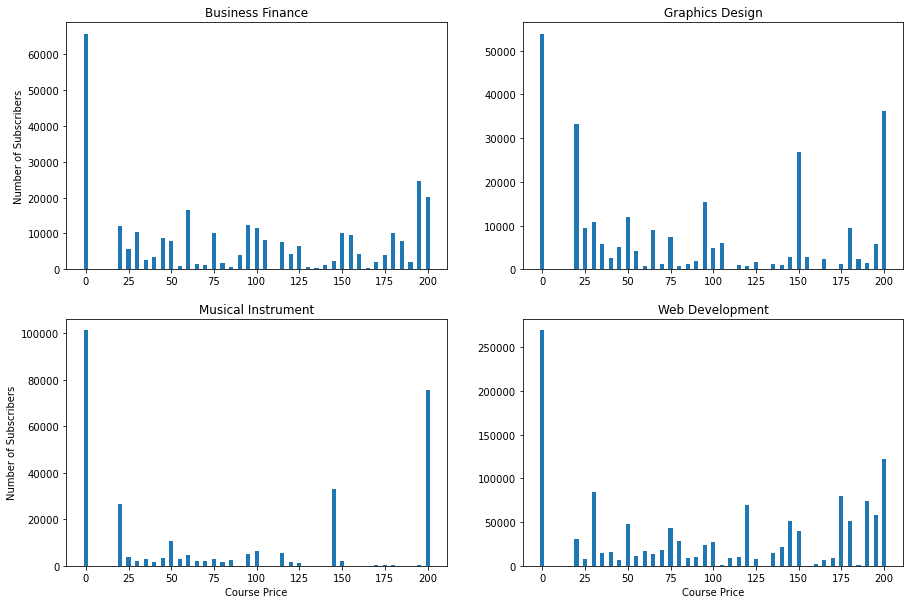

In [27]:
#course price versus number of subscribers
fig, ((ax0, ax1), (ax2, ax3 )) = plt.subplots(2,2 ,figsize=(15,10))

ax0.bar(df_biz.price, df_biz['num_subscribers'], width=2.4)
ax0.set_title('Business Finance')
ax0.set_ylabel('Number of Subscribers')

ax1.bar(df_gfx.price, df_gfx.num_subscribers, width=2.4)
ax1.set_title('Graphics Design')

ax2.bar(df_mus.price, df_mus.num_subscribers, width=2.4)
ax2.set_title('Musical Instrument')
ax2.set_xlabel('Course Price')
ax2.set_ylabel('Number of Subscribers')

ax3.bar(df_dev.price, df_dev.num_subscribers, width=2.4)
ax3.set_title('Web Development')
ax3.set_xlabel('Course Price')

plt.show()

Let us see the common words used to frame courses that have above 4-star rating and above average number of subscription across the different subjects.

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


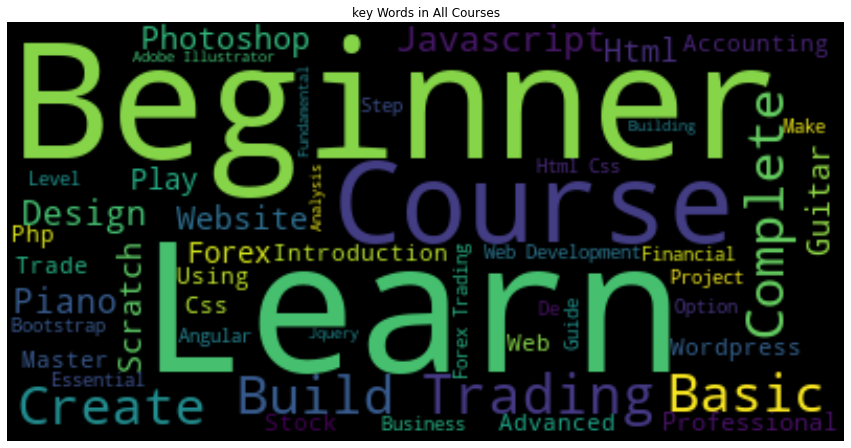

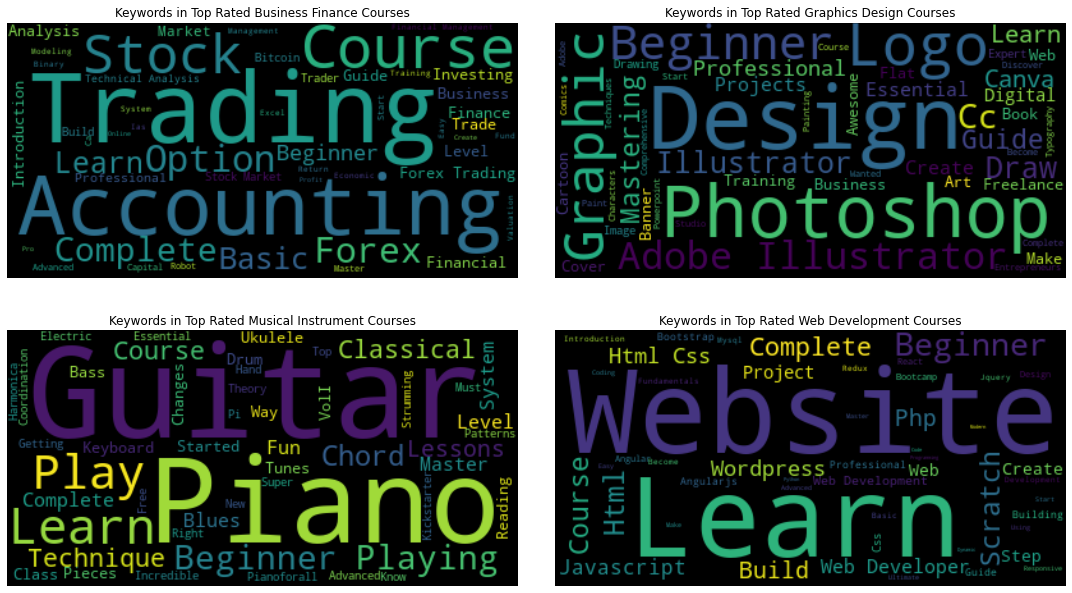

In [28]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
snowball = SnowballStemmer(language = 'english')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

#instantiate lemmatize; change words in past to present, third person to first person
wn = WordNetLemmatizer()
    
stopword = set(stopwords.words('english'))

def word_join(text):
    text = (' '.join([word for word in text.split(' ') if word not in stopword]))
    text = ' '.join([wn.lemmatize(word, pos='v') for word in text.split(' ')])
    return text


text = ' '.join(word for word in df['course_title'].apply(word_join))
wordcloud = WordCloud(stopwords = set(STOPWORDS), background_color = 'black', max_words=50).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('key Words in All Courses')
plt.axis('off')
plt.show()

#plot words for the top rated courses
fig, ((ax0, ax1), (ax2, ax3 )) = plt.subplots(2,2 ,figsize=(15,10))

df_bizt = df_biz.query('star_rating >= 4 & num_subscribers > 1569') #above average number of subscribers
text = ' '.join(word for word in df_bizt['course_title'].apply(word_join))
wordcloud = WordCloud(stopwords = set(STOPWORDS), background_color = 'black', max_words=50).generate(text)
ax0.imshow(wordcloud, interpolation='bilinear')
ax0.set_title('Keywords in Top Rated Business Finance Courses')
fig.tight_layout()
ax0.axis("off")

df_gfxt = df_gfx.query('star_rating >= 4 & num_subscribers > 1766') #above average number of subscribers
text = ' '.join(word for word in df_gfxt['course_title'].apply(word_join))
wordcloud = WordCloud(stopwords = set(STOPWORDS), background_color = 'black', max_words=50).generate(text)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set_title('Keywords in Top Rated Graphics Design Courses')
fig.tight_layout()
ax1.axis("off")

df_must = df_mus.query('star_rating >= 4 & num_subscribers > 1245') #above average number of subscribers
text = ' '.join(word for word in df_must['course_title'].apply(word_join))
wordcloud = WordCloud(stopwords = set(STOPWORDS), background_color = 'black', max_words=50).generate(text)
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.set_title('Keywords in Top Rated Musical Instrument Courses')
fig.tight_layout()
ax2.axis("off")

df_devt = df_dev.query('star_rating >= 4 & num_subscribers > 6635') #above average number of subscribers
text = ' '.join(word for word in df_devt['course_title'].apply(word_join))
wordcloud = WordCloud(stopwords = set(STOPWORDS), background_color = 'black', max_words=50).generate(text)
ax3.imshow(wordcloud, interpolation='bilinear')
ax3.set_title('Keywords in Top Rated Web Development Courses')
fig.tight_layout()
plt.axis("off")
warnings.filterwarnings("ignore")
plt.show()

More than 42% of the courses for each subject were rated high.

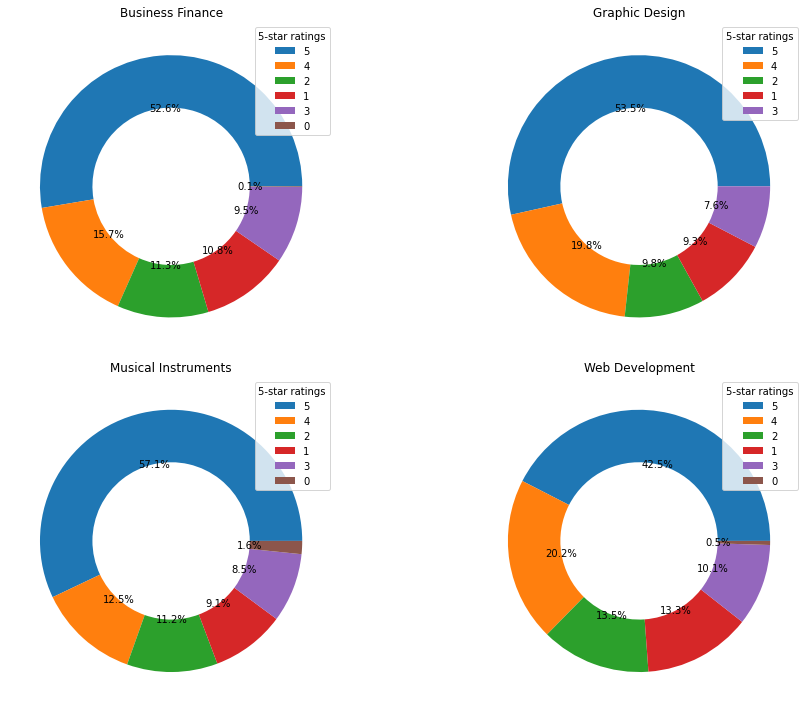

In [29]:
#pieplot for the different courses
# use 5 for number of bins
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2 ,figsize=(15,10))

labels = [0,1,2,3,4,5]

ax0.pie(df_biz['star_rating'].value_counts(), autopct='%1.1f%%',  wedgeprops=dict(width=.4))
ax0.legend(df_biz['star_rating'].value_counts().index,title = '5-star ratings')
ax0.set_title('Business Finance')

ax1.pie(df_gfx['star_rating'].value_counts(), autopct='%1.1f%%',   wedgeprops=dict(width=.4))
ax1.legend(df_biz['star_rating'].value_counts().index,title = '5-star ratings')
ax1.set_title('Graphic Design')

ax2.pie(df_mus['star_rating'].value_counts(), autopct='%1.1f%%',  wedgeprops=dict(width=.4))
ax2.legend(df_biz['star_rating'].value_counts().index,title = '5-star ratings')
ax2.set_title('Musical Instruments')

ax3.pie(df_dev['star_rating'].value_counts(), autopct='%1.1f%%',  wedgeprops=dict(width=.4))
ax3.legend(df_biz['star_rating'].value_counts().index,title = '5-star ratings')
ax3.set_title('Web Development')

fig.tight_layout()
plt.show()

For the paid courses, they're more of *general* category and *Web Development* courses.

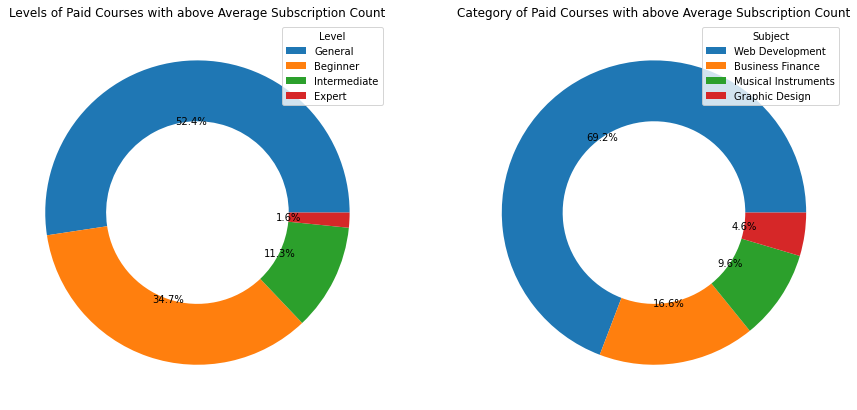

In [30]:
fig, ((ax0), (ax1)) = plt.subplots(1,2 ,figsize=(15,10))

#paid courses with above average subscription
subject = df[(df['num_subscribers']>3199) & (df['price_group'] != 'free')]['level'].value_counts()
ax0.pie(subject, autopct='%1.1f%%',   wedgeprops=dict(width=.4))
ax0.legend(df['level'].value_counts().index, title = 'Level')
ax0.set_title('Levels of Paid Courses with above Average Subscription Count')

#paid courses with above average subscription
subject1 = df[(df['num_subscribers']>3199) & (df['price_group'] != 'free')]['subject'].value_counts()
ax1.pie(subject1, autopct='%1.1f%%',   wedgeprops=dict(width=.4))
ax1.legend(df['subject'].value_counts().index, title = 'Subject')
ax1.set_title('Category of Paid Courses with above Average Subscription Count')

plt.show()

There is a consistent year-on-year growth in the number of published courses across all the subjects untill 2016. The earliest course for *Web Development* was published in July 2011 and mid 2012 for the other subjects while the lattest course came in July 2017. Thus *FY 2017* figures may not actually show a decline from the previous year.

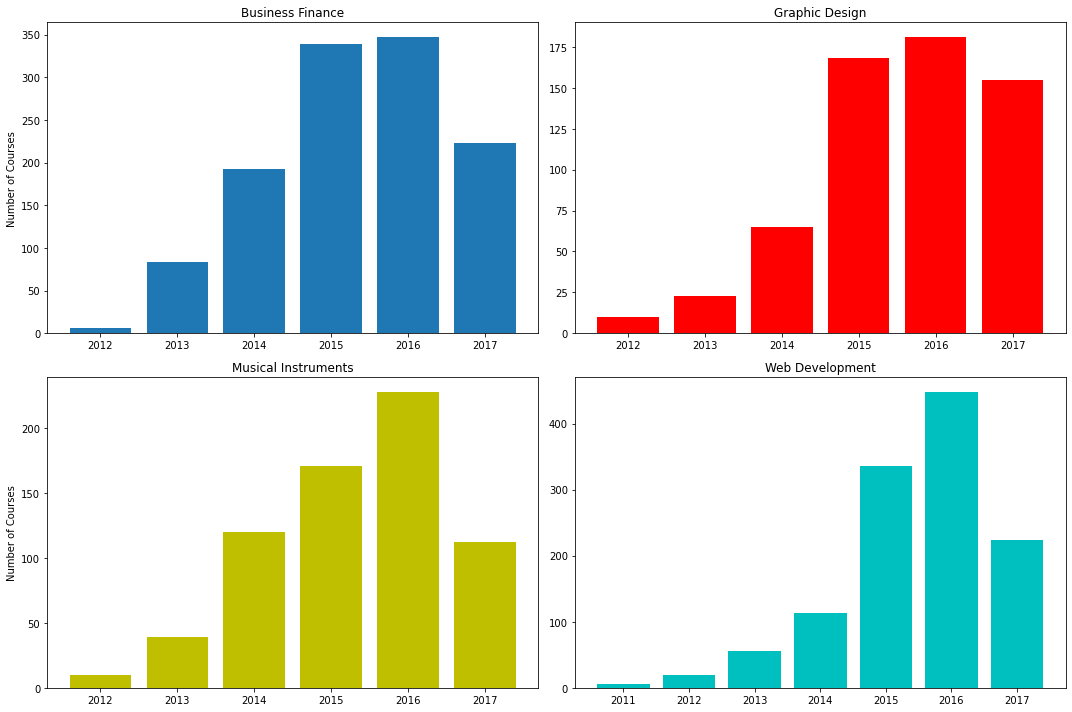

In [31]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2 ,figsize=(15,10))

labels = [0,1,2,3,4,5]

ax0.bar(df_biz.year.value_counts().index,df_biz.year.value_counts().values)
ax0.set_title('Business Finance')
ax0.set_ylabel('Number of Courses')

ax1.bar(df_gfx.year.value_counts().index,df_gfx.year.value_counts().values,color='r')
ax1.set_title('Graphic Design')

ax2.bar(df_mus.year.value_counts().index,df_mus.year.value_counts().values,color='y')
ax2.set_title('Musical Instruments')
ax2.set_ylabel('Number of Courses')

ax3.bar(df_dev.year.value_counts().index,df_dev.year.value_counts().values, color='c')
ax3.set_title('Web Development')

fig.tight_layout()
plt.show()

Below is the year-on-year revenue generation for the subjects.

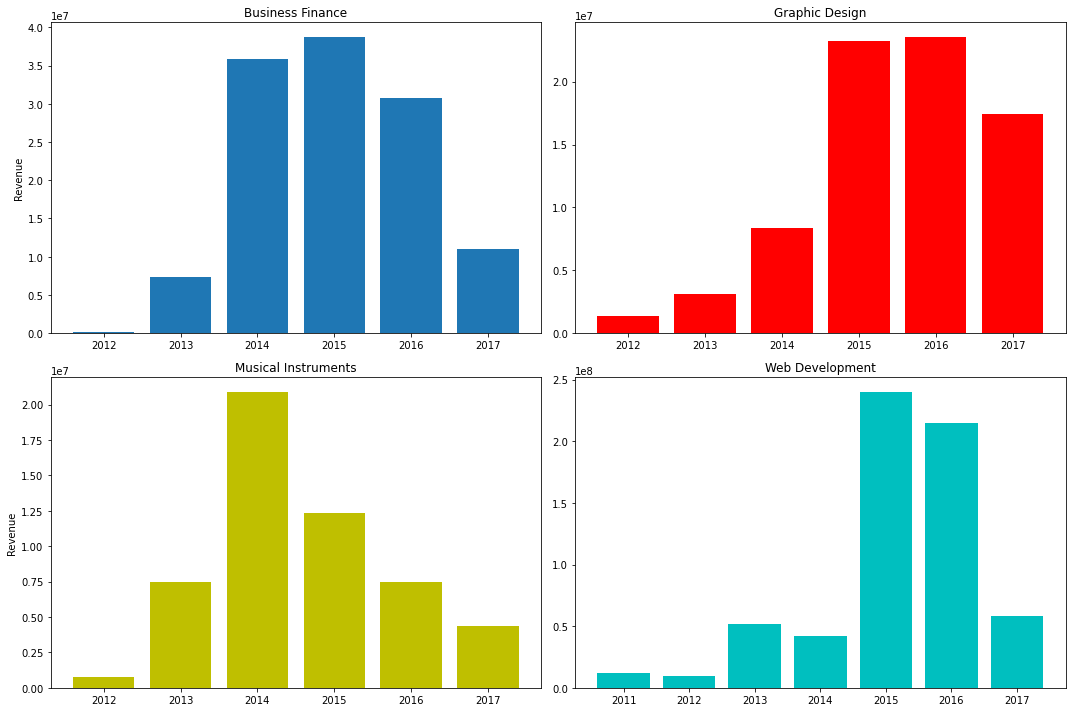

In [32]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2 ,figsize=(15,10))

labels = [0,1,2,3,4,5]

ax0.bar(df_biz.groupby('year')['revenue'].sum().index, df_biz.groupby('year')['revenue'].sum())
ax0.set_title('Business Finance')
ax0.set_ylabel('Revenue')

ax1.bar(df_gfx.groupby('year')['revenue'].sum().index, df_gfx.groupby('year')['revenue'].sum(), color='r')
ax1.set_title('Graphic Design')

ax2.bar(df_mus.groupby('year')['revenue'].sum().index, df_mus.groupby('year')['revenue'].sum(),color='y')
ax2.set_title('Musical Instruments')
ax2.set_ylabel('Revenue')

ax3.bar(df_dev.groupby('year')['revenue'].sum().index, df_dev.groupby('year')['revenue'].sum(), color='c')
ax3.set_title('Web Development')

fig.tight_layout()
plt.show()

### Comments

- The dataset is limited to only four subject areas while leaving out a ton of interesting areas including Data Science, Cyber Security, Cloud Computing, Digital Marketing.
- The dataset is not updated to the current year, 2022. It would have been nice to see how digital learning grew in the Covid-19 era.
- There are no demographic data on the subscribers and the duration of their learning of the chosen subject.
- The rating of the courses didnt provide details of the comments made by the subscribers.
- It was *not* expressely stated what the unit of the course duration was -  whether hours or minutes.
- It was not explained what the scale of the `Rating` was; does a rating of 0.0 mean there was no rating at all or the course received the least score.
- There is no data on the content creators; it would have been great to know which tutors make the most subscribed and best rated contents.

### Conclusions
- `Web Development` and `Graphics Designs` have the highest and lowest number of published courses respectively.
- Subscribers are more interested in `Web Development` courses and least in `Musical Instruments` courses.
- `Graphics Design` courses followed by `Business Finance` received the best ratings.
- `Web Development` courses are more expensive, attractive more subscribers; hence generate the highest revenue.
- The % of the courses that are free are more in expert level.
- For courses with high rating and subscriptions, they are courses on Accounting, Forex, Stock in Business Finance; Photoshop, Adobe Illustrator in Graphics Design; Piano and Guitar in Musical Instruments and HTML, CSS, building a Website in Web Development.
- The courses received high ratings across board.
- The year 2016 has highest number of courses published across the different subjects.
- For revenue generation, 2014 was the big year for `Musical Instruments`, 2015 for `Business Finance` and `Web Development` while `Graphics Design` made the most revenue in 2016.